# Sequence Modelling with RNNs

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

```text
𝗔𝘁𝘁𝗿𝗶𝗯𝘂𝘁𝗶𝗼𝗻: Notes for Chapter 9: Recurrent Neural Networks of (Dive into Deep Learning) d2l.ai.
```

---

## Introduction

Recall that for MLPs we have inputs $\mathbf x \in \mathbb R^d$ that is transformed by passing data to a sequence of layers. Similarly, for CNNs we also have fixed-length inputs for images, and sequential feature extraction. The only difference is the operations implemented in the layers (i.e. instead of dense layers, we have convolution blocks). These networks are designed to capture heirarchical structure of input data. Observe that the data points for these problems are of fixed length. On the other hand, many problems have data that cannot be represented as fixed length vectors, i.e. we have variable-length sequential data, such as video, sensor readings, text or natural language data. 

The key insight is that while sequential data have variable length, we can model each sequence as having an evolving state which is a fixed-length vector $(\mathbf x_1, \ldots, \mathbf x_T)$ such that $\mathbf x_i \in \mathbb R^d$ for $t = 1, \ldots, T$ where $T \in \mathbb N.$ For example, documents can be modelled as variable length sequences of fixed-length vector representations of words. Medical diagnoses can be interpreted as a sequence of events that represent the state of patients represented as fixed-length vectors. And videos can be modeled as varying length sequences of images of fixed size. 

```{margin}
Figure source:<br>
[`d2l.ai/ch9`](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html)
```
```{figure} ../../img/unfolded-rnn.svg
---
width: 80%
name: unfolded-rnn
---
Unrolling an RNN unit with recurrent connections (cyclic edges).
```

To model sequential data we will look at **recurrent neural networks** (**RNN**) which capture the dynamics of sequences using recurrent connections ({numref}`unfolded-rnn`). This framework allows inputs to be processed in a feed-forward manner with layer weights shared across time steps. Note that an RNN with unrolled layers looks very familiar. In fact, we can backpropagate through RNNs, although this introduces difficulties in training, motivating modern RNN architectures that we will discuss in the next notebook.

In [1]:
import re
import os
import random as pyrandom
import warnings
import collections
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import tensorflow as tf
import tensorflow.keras as kr


def tf_enable_determinism(seed=None):
    # https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html
    if seed is not None:
        tf.keras.utils.set_random_seed(seed)            # py, np, and tf
        tf.config.experimental.enable_op_determinism()  # tensorflow op (slower!)


DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')
tf_enable_determinism(seed=RANDOM_SEED)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Sequence modelling

Some datasets consists of a single massive sequence. For example, readings of a single sensor over a period of time, or sales figures over five years. Previously when dealing with vector inputs $\mathbf x \in \mathbb R^d$, we assumed $\mathbf x \sim p$ where $p$ is an underlying distribution. We will still assume that entire sequences in a dataset are sampled independently and identically. That is, we will assume that documents in a collection are generated by the same random process. But, of course, we cannot assume that a word $\mathbf x_t$ is independent of the previous word $\mathbf x_{t-1}$ in a document. This is why we expect the beginning of a sentence to be different from its end.

**Outputs.** Regarding outputs, we sometimes want to model a single target given a sequence as input (e.g. sentiment analysis). Or a sequence of targets which aligns with the given input in a 1-1 manner (e.g. image captioning). But the length of the output sequence can also differ from the input sequence (e.g. machine translation). In this case outputs cannot be aligned since there is no 1-1 mapping at each time step.

### Density estimation

Before we do supervised learning between sequences, we first consider the problem of unsupervised estimation of the probability mass function given a collection of sequences. That is, we want to estimate the probability of any sequence $p(\mathbf x_1, \ldots, \mathbf x_T).$ This should give us some basic intuitions and statistical tools for dealing with sequence data.

### Autoregressive models

Let us consider the problem of predicting the next value of a real variable, i.e. we want to model $p(x_t \mid x_1, \ldots x_{t-1}).$ Since estimating the continuous distribution of possible values at time $t,$ we can instead model the mean of the distribution $\hat x_t = \mathbb E[x_t \mid x_1, \ldots, x_{t-1}].$ This can be our estimate which can be modelled (e.g. by a linear regression model). Such a model is called an **autoregressive model**. A problem is that for increasing $t,$ the length of the input to the model also increases. Two approaches to sidestep this problem are:



* **Fixed window.** One strategy is to only look at $(x_{t_1}, \ldots, x_{t-\tau})$, i.e. $\tau$ time steps in the past. The immediate benefit is that for $t > \tau$ the input to the model has fixed length. This allows us to train any linear model or deep network that requires fixed-length vectors as inputs. 
<br><br>

* **Latent representation.** Another approach is to have a hidden or latent representation $h_t$ of past states which we use to predict $x_t.$ For example, we can predict $\hat x_t = \mathbb E[x_t \mid h_t]$ such that $h_t = \Upsilon(h_{t-1}, x_{t-1})$ where $\Upsilon$ is some update rule for the hidden state ({numref}`latent-autoregressive`).

```{margin}
Figure source:<br>
[`d2l.ai/ch9`](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html)
```
```{figure} ../../img/latent-autoregressive.png
---
width: 60%
name: latent-autoregressive
---
A latent autoregressive model.
```

### Markov models

Note that by the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)) we can write the following decomposition where each conditional probability on the right hand side is probability distribution of the next word given the previous context:

$$p(\mathbf x_1, \ldots, \mathbf x_T) = p(\mathbf x_1)\prod_{t=2}^T p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1}, \ldots, {\mathbf x}_{1}\right).$$

The conditional probabilities can be intractiable, so instead we can use the strategy above of only using past $\tau$ observations. This is called a **Markov condition** where we model future events to be only conditionally dependent on recent events. For example, we can take $\tau = 1$ (first-order Markov model) so that

$$p(\mathbf x_1, \ldots, \mathbf x_T) = p(\mathbf x_1)\prod_{t=2}^T p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1}\right).$$

This is a way easier problem than above. In this case, the probability of the entire sentence is a product of the probabilities of the next word given the current word multiplied by the probability of the first word. Of course, higher $\tau$ is better but the gain diminishes rapidly so we can tune this to be of a reasonable size. Note that $p\left({\mathbf x}_{t} \mid {\mathbf x}_{t-1} \ldots {\mathbf x}_{t-\tau} \right)$ can be estimated computed by counting relative frequencies.

### Modelling synthetic data

Before we focus our attentions on text data, let’s first try this out with some continuous-valued synthetic data. Our goal is to predict the **next value** of the sequence.

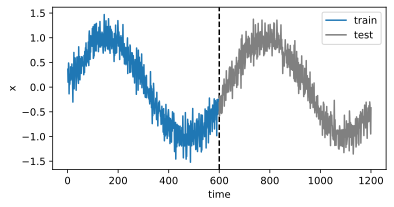

In [2]:
T = 1200
t = np.arange(1, T + 1)
x = np.sin(0.01 * t) + np.random.normal(size=T) * 0.2

noisy_data = pd.DataFrame({'t': t, 'x': x})

cutoff = int(0.50 * T)

plt.figure(figsize=(6, 3))
plt.axvline(x=cutoff, linestyle='dashed', color='black')
plt.plot(noisy_data.query(f't  < {cutoff}').t, noisy_data.query(f't  < {cutoff}').x, label='train')
plt.plot(noisy_data.query(f't >= {cutoff}').t, noisy_data.query(f't >= {cutoff}').x, label='test', color='gray')

plt.legend()
plt.ylabel('x')
plt.xlabel('time');

#### $\tau$-order Markov

To begin, we try a model that acts as though the data satisfied a $\tau$-order Markov condition, and thus predicts $x_{t}$ using only the past $\tau$ observations. For each timestep, we have an example with label $y=x_{t}$ and features $\mathbf{x}_{t}=\left[x_{t-\tau}, \ldots, x_{t-1}\right]$. Data points at $t < \tau$ are simply dropped.

In [3]:
def create_features(data, tau):

    # Create lag features
    X = pd.concat([data[['x']].shift(i) for i in range(tau)], axis=1)
    X.columns = [f'x(t-{i})' if i > 0 else 'x(t)' for i in range(0, tau)]

    # Create target
    X['x(t+1)'] = data[['x']].shift(-1).values
    X['t'] = data.t

    # Rearranging columns: left to right
    cols = ['t'] + [f'x(t-{tau-i})' if i > 0 else 'x(t)' for i in range(1, tau)] + ['x(t)', 'x(t+1)']
    X = X[cols]
    
    return X

Fourth order:

In [4]:
tau = 4
X = create_features(noisy_data, tau=tau)
X

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,1,NaN,NaN,NaN,0.362810,0.100030
1,2,NaN,NaN,0.362810,0.100030,0.225743
2,3,NaN,0.362810,0.100030,0.225743,0.488168
3,4,0.362810,0.100030,0.225743,0.488168,0.423491
4,5,0.100030,0.225743,0.488168,0.423491,-0.135492
...,...,...,...,...,...,...
1195,1196,-0.628973,-0.688214,-0.299574,-0.362372,-0.557885
1196,1197,-0.688214,-0.299574,-0.362372,-0.557885,-0.672097
1197,1198,-0.299574,-0.362372,-0.557885,-0.672097,-0.947361
1198,1199,-0.362372,-0.557885,-0.672097,-0.947361,-0.418632


In fact, a larger $\tau$ seems to impact predictions close to the test point negatively.

In [5]:
train = X.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = X.query(f't >= {cutoff}').dropna().reset_index(drop=True)

train.head()

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,4,0.362810,0.100030,0.225743,0.488168,0.423491
1,5,0.100030,0.225743,0.488168,0.423491,-0.135492
2,6,0.225743,0.488168,0.423491,-0.135492,0.259961
3,7,0.488168,0.423491,-0.135492,0.259961,0.049643
4,8,0.423491,-0.135492,0.259961,0.049643,0.069235


In [6]:
test.head()

,t,x(t-3),x(t-2),x(t-1),x(t),x(t+1)
0,600,-0.402097,-0.341908,-0.475034,-0.315133,-0.579886
1,601,-0.341908,-0.475034,-0.315133,-0.579886,-0.176694
2,602,-0.475034,-0.315133,-0.579886,-0.176694,-0.439363
3,603,-0.315133,-0.579886,-0.176694,-0.439363,-0.193175
4,604,-0.579886,-0.176694,-0.439363,-0.193175,-0.512270


Fit next step prediction model:

In [7]:
model = LinearRegression()
model.fit(train.drop(['t', 'x(t+1)'], axis=1).values, train['x(t+1)'])

LinearRegression()

In [8]:
pred = model.predict(train.drop(['t', 'x(t+1)'], axis=1).values)
print('train rmse:', mean_squared_error(train['x(t+1)'], pred, squared=False))

pred = model.predict(test.drop(['t', 'x(t+1)'], axis=1).values)
print('test  rmse:', mean_squared_error(test['x(t+1)'], pred, squared=False))

train rmse: 0.22638210088979385
test  rmse: 0.21213347239603786


A good test performance is expected since the train and test distributions are identical.

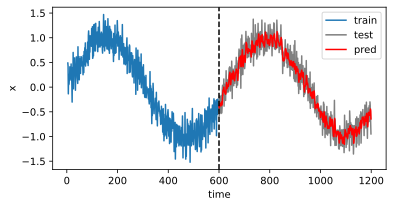

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(train.t, train['x(t)'], zorder=1, label='train')
plt.plot(test.t, test['x(t)'], zorder=1, color='gray', label='test')
plt.plot(test.t, pred, color='red', zorder=2, label='pred')
plt.axvline(x=cutoff, linestyle='dashed', color='black')
plt.xlabel('time')
plt.ylabel('x')
plt.legend();

#### Future steps prediction

Suppose the current time step is $t = 800$ without any knowledge of future time steps. For the fourth-order model above we predicted $\hat{x}_{800}=f\left(x_{796}, x_{797}, x_{798}, x_{799}\right).$ Observe that predicting $k > 1$ time steps into the future doesn't work directly using $f$ because there will be missing data points (i.e. unobserved data points). One thing we can do is to use the model to fill in gaps with predictions:

$$
\begin{aligned}
&f\left(x_{796}, x_{797}, x_{798}, x_{799}\right) = \hat{x}_{800} \\
&f\left(x_{797}, x_{798}, x_{799}, \hat{x}_{800}\right) = \hat{x}_{801}\\
&f\left(x_{798}, x_{799}, \hat{x}_{800}, \hat{x}_{801}\right) = \hat{x}_{802} \\
&f\left(x_{799}, \hat{x}_{800}, \hat{x}_{801}, \hat{x}_{802}\right) = \hat{x}_{803}\\
&f\left(\hat{x}_{800}, \hat{x}_{801}, \hat{x}_{802}, \hat{x}_{803}\right) = \hat{x}_{804}
\end{aligned}
$$

We say that this is $k = 1, 2, 3, 4, 5$ step predictions with $\tau=4.$ Let's check the accuracy of this model. For convenience we will define a class.

In [10]:
class ForecastModel:
    
    def __init__(self, tau, data, cutoff):
        """Pass all known data for 𝜏-order model."""
        self.tau = tau
        self.data = data
        self.model_ = None
        self.features_ = create_features(data, tau).dropna()
        
        # Train next step prediction model below cutoff
        train = self.features_.query(f't < {cutoff}')
        model = LinearRegression()
        model.fit(train.drop(['t', 'x(t+1)'], axis=1).values, train['x(t+1)'])
        self.model_ = model


    def predict(self, t, k=1):
        """Use features [x(t-𝜏+1), ..., x(t)] to predict [x(t+1), ..., x(t+k)]."""

        # Construct features table as in the above equations
        preds = [0] * k
        features = self.features_.query(f't == {t}').drop(['t', 'x(t+1)'], axis=1)
        features = list(features.iloc[0])
        for i in range(k):
            preds[i] = self.model_.predict(np.array(features).reshape(1, -1))[0]
            features = features[1:] + [preds[i]]

        return preds

Below, we forecast $k = 1, 2, \ldots, 300$ from $t = 799$ as described in the above equations with a regression model trained with next step prediction on the time points indicated in the plot. Recall that the above model is able to perform well beyond the train cutoff point $t=600.$ So we will use that.

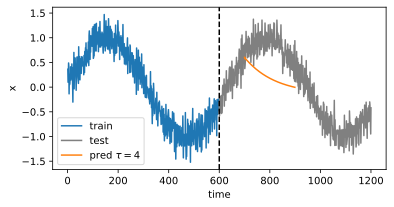

In [11]:
cutoff = 600
train = noisy_data.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = noisy_data.query(f't >= {cutoff}').dropna().reset_index(drop=True)

plt.figure(figsize=(6, 3))
plt.plot(train.t, train.x, label='train')
plt.plot(test.t, test.x, label='test', color='gray')
plt.axvline(x=cutoff, linestyle='dashed', color='black')

# Plot forecasts
t0 = 699
k_step_model = ForecastModel(tau=4, data=noisy_data, cutoff=cutoff)
preds = k_step_model.predict(t=t0, k=200)
plt.plot(
    [t0+k for k in range(1, 200+1)],
    preds, color='C1', zorder=3, label=r'pred $\tau = 4$'
)

plt.legend()
plt.ylabel('x')
plt.xlabel('time');

Why did the algorithm perform so much worse? Ultimately, this owes to the fact that errors build up at each prediction step since the model incorporates prediction noise into its features. After a certain point, the predictions become meaningless.

#### Increasing $\tau$

If we look at the evolution of the absolute error, having a larger $\tau$ results in better error rates further into the future. This only works due to the stationary nature of the data. In general, trying to model currently missing features (future values) using a regression model appears to be a bad idea.

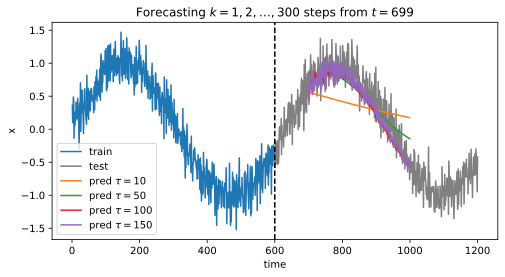

In [12]:
cutoff = 600
train = noisy_data.query(f't  < {cutoff}').dropna().reset_index(drop=True)
test  = noisy_data.query(f't >= {cutoff}').dropna().reset_index(drop=True)

plt.figure(figsize=(8, 4))
plt.plot(train.t, train.x, label='train')
plt.plot(test.t, test.x, label='test', color='gray')
plt.axvline(x=cutoff, linestyle='dashed', color='black')

# Plot forecasts
t0 = 699
tau_range = [10, 50, 100, 150]
for i, tau in enumerate(tau_range):
    k_step_model = ForecastModel(tau=tau, data=noisy_data, cutoff=cutoff)
    preds = k_step_model.predict(t=t0, k=300)
    plt.plot(
        [t0+k for k in range(1, 300+1)],
        preds, color=f'C{i+1}', zorder=3+i, label=r'pred $\tau = $' + f'{tau}'
    )

plt.legend()
plt.ylabel('x')
plt.xlabel('time')
plt.title(r'Forecasting $k = 1, 2, \ldots, 300$ steps from $t = $' + f'{t0}');

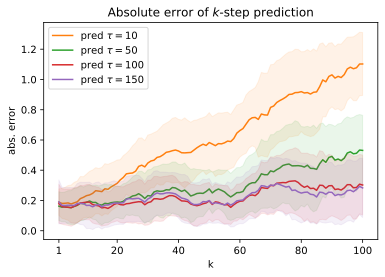

In [13]:
# Plot forecasts
k = 100
t0_range = range(600, 620+1)
errors = { tau:[] for tau in tau_range }
fig, ax = plt.subplots()

for i, tau in enumerate(tau_range):

    # Fit model and compute errors for each t0
    k_step_model = ForecastModel(tau=tau, data=noisy_data, cutoff=cutoff)  
    for t0 in t0_range:
        actual = noisy_data.query(f't in {[t0+k for k in range(1, k+1)]}').x
        preds = k_step_model.predict(t=t0, k=k)
        errors[tau].append(np.abs(preds - actual).values)

    # Plot average of each k over all t0
    errors[tau] = pd.DataFrame(errors[tau])
    x = range(1, k+1)
    y = errors[tau].describe().loc['mean']
    σ = errors[tau].describe().loc['std']
    yp = y + σ
    yn = y - σ
    plt.fill_between(x, yp, yn, color=f'C{i+1}', zorder=3+i, alpha=0.1)
    ax.plot(x, y, color=f'C{i+1}', zorder=3+i, label=r'pred $\tau = $' + f'{tau}')


plt.legend()
plt.xlabel('k')
plt.ylabel(f'abs. error')
plt.xticks([1, 20, 40, 60, 80, 100])
plt.title(r'Absolute error of $k$-step prediction');

Here absolute error curves are averaged for $k$-step predictions over prediction points $t \in [600, 620].$ Note that there seems to be little gain in going from $\tau = 100$ to $\tau = 150$.

## Text data to sequences

In practice, we will often work with text data represented as sequences of words or characters. In this section, we look at basic tools for converting raw text into sequences of the appropriate form. A typical preprocessing pipeline has the following steps:

1. Load text as strings into memory.
2. Split the strings into tokens (e.g., words or characters).
3. Build a vocabulary which maps each element to a numerical index.
4. Convert the text into sequences of numerical indices using the mapping.

**Remark.** We will focus mostly on text data since core problems of NLP motivated basic research in RNNs. But methods developed in this domain transfers easily to other application domains.

In [22]:
!mkdir data
!wget http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt -O ./data/timemachine.txt

--2022-08-11 19:41:46--  http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 54.192.19.52
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|54.192.19.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178979 (175K) [text/plain]
Saving to: ‘./data/timemachine.txt’

./data/timemachine. 100%[===================>] 174.78K   882KB/s    in 0.2s    

2022-08-11 19:41:47 (882 KB/s) - ‘./data/timemachine.txt’ saved [178979/178979]



In [23]:
with open('./data/timemachine.txt') as f:
    raw_text = f.read()
    
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

For simplicity, we ignore punctuation and capitalization:

In [24]:
text = re.sub('[^A-Za-z]+', ' ', raw_text).lower()

print('Raw:', repr(raw_text[:60]))
print('Preprocessed:', repr(text[:60]))

Raw: 'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'
Preprocessed: 'the time machine by h g wells i the time traveller for so it'


### Tokenization

Tokens are atomic units of text. What precisely is a token is a design choice. For example, we can reduce sentences into words where the set of words comprise a large vocabulary. Or we can reduce a sentence into characters where the vocabulary contains only 256 ASCII characters. This is shown below:

In [25]:
print(','.join(list(text)[:30]))
print(','.join(list(text.split())[:30]))

t,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, 
the,time,machine,by,h,g,wells,i,the,time,traveller,for,so,it,will,be,convenient,to,speak,of,him,was,expounding,a,recondite,matter,to,us,his,grey


### Constructing the vocabulary

A **vocabulary** is simply a mapping from tokens to a unique index. First, we determine the set of unique tokens in our training data. Each token is mapped to a numerical index. Rare vocabulary elements can be dropped to reduce the number of tokens. Tokens that had not been previously seen (or was dropped) from the vocabulary is represented by a special `<unk>` token which is mapped to index `0`.

In [26]:
class Vocab:    
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Vocabulary for text."""
        
        # Count token frequencies; sort decreasing based on counts
        counter = collections.Counter(tokens)
        self.token_freqs_ = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        # The list of unique tokens sorted alphabetically
        self._idx_to_token = list(['<unk>'] + reserved_tokens 
            + sorted([token for token, freq in self.token_freqs_ if freq >= min_freq])
        )
        
        # Inverse mapping
        self._token_to_idx = { 
            token: idx for idx, token in enumerate(self._idx_to_token)
        }

    @property
    def unk_idx(self):
        """Index for the unknown token."""
        return self._token_to_idx['<unk>']

    def __len__(self):
        return len(self._idx_to_token)

    def __getitem__(self, tokens):
        """Convert token (/tokens) to index (/index list)."""

        if not isinstance(tokens, (list, tuple)):
            return self._token_to_idx.get(tokens, self.unk_idx)
        
        return [self.__getitem__(token) for token in tokens]


    def inverse(self, indices):
        """Convert index (/indices) to token (/token list)."""

        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self._idx_to_token[int(index)] for index in indices]
        
        return self._idx_to_token[indices]

Let's construct a vocabulary of words in the text. This keeps a frequency count:

In [27]:
vocab = Vocab(
    tokens=list(text.split()),
    min_freq=10,
    reserved_tokens=['@', '#']
)

print(len(vocab))
print(vocab.token_freqs_[:5])
print(vocab.token_freqs_[-5:])

402
[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816)]
[('cheerlessly', 1), ('advancement', 1), ('makers', 1), ('casual', 1), ('brittle', 1)]


The main function of the vocabulary is to map tokens to indices:

In [28]:
print(vocab['123@#@33X']) # '123@#@33X' -> '<unk>'
print(vocab['1231??XXX', 'above', 'about', 'a'])

0
[0, 5, 4, 3]


Inverse mapping indices to tokens:

In [29]:
print(vocab.inverse(0))
print(vocab.inverse([0, 1, 2, 3, 4, 5]))

<unk>
['<unk>', '@', '#', 'a', 'about', 'above']


### Constructing the text dataset

For convenience, we collect everything in a class for processing the raw data. Note that we tokenize the raw text based on characters instead of words. This is because we will do character generation later. Here **corpus** simply means the sequence of numbers (i.e. tokens mapped by the vocabulary to integers) that represent our preprocessed dataset.

In [30]:
class TimeMachine:
    def __init__(self, 
            vocab=None,
            tokenizer=lambda text: list(text)
        ):
        """Dataset builder for H.G. Wells' Time Machine."""

        self.raw_text = (DATASET_DIR / 'timemachine.txt').read_text()
        self.tokenizer = tokenizer
        self.tokens_ = self._tokenize(self._preprocess(self.raw_text))
        self.vocab_ = vocab or Vocab(self.tokens_)
        self.corpus_ = [ self.vocab_[t] for t in self.tokens_ ]

    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return self.tokenizer(text)

    def build(self):
        """Build corpus and vocabulary."""
        return self.corpus_, self.vocab_


tm_chars = TimeMachine()
corpus, vocab = tm_chars.build()

print('Vocab size:', len(vocab))
print('Corpus size:', len(corpus))
print(corpus[:16])
print(vocab.inverse(corpus[:16]))

Vocab size: 28
Corpus size: 173428
[21, 9, 6, 1, 21, 10, 14, 6, 1, 14, 2, 4, 9, 10, 15, 6]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e']


### Exploratory language statistics

Going back to word tokenization. Note that the frequent words are mostly **stop words** which are not special to the current text. That is we can expect the same words in a randomly chosen text. 

In [31]:
tm_words = TimeMachine(tokenizer=lambda t: list(t.split()))
corpus, vocab = tm_words.build()

vocab.token_freqs_[:18]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204)]

In previous generations of text classifiers based on bag-of-words representations, they were most often filtered out, as they only contribute noise. However, if we look at the sequential structure of sentences, they carry meaning. More modern RNN and Transformer-based networks are able to extract meaning from stop words.

#### Zipf's law

Plotting token frequency:

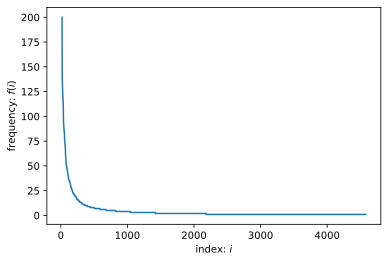

In [32]:
f = [j for (word, j) in vocab.token_freqs_]

plt.plot(range(18, len(f)), f[18:]) # skipping stop words
plt.xlabel('index: $i$')
plt.ylabel('frequency: $f(i)$');

Plotting this in log-log scale shows an approximately linear relationship:

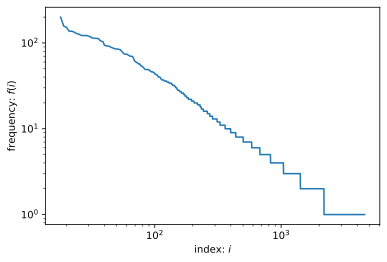

In [33]:
plt.plot(range(18, len(f)), f[18:]);

plt.yscale('log')
plt.xscale('log')
plt.xlabel('index: $i$')
plt.ylabel('frequency: $f(i)$');

This is known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law). Rearranging, we get a power law $f \propto i^{-\alpha}$ for the token frequency with fixed decay rate $\alpha.$ Since the mass of the distribution is tail-heavy, this means that language models that rely on counting statistics will probably overestimate the frequency of infrequent words.

#### Looking at *n*-grams

To capture more meaning and context, we can try tokenizing using subsequences of words. These are called **bigrams** for two consecutive words, and **trigrams** for three. Observe below that the most frequent bigrams still look like stop words. But this starts to change with trigrams.

In [34]:
words = tm_words.tokens_

bigram_tokens = [f'{w1}—{w2}' for (w1, w2) in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(tokens=bigram_tokens)
bigram_vocab.token_freqs_[:10]

[('of—the', 309),
 ('in—the', 169),
 ('i—had', 130),
 ('i—was', 112),
 ('and—the', 109),
 ('the—time', 102),
 ('it—was', 99),
 ('to—the', 85),
 ('as—i', 78),
 ('of—a', 73)]

Trigrams are starting to look better:

In [35]:
trigram_tokens = [f'{w1}—{w2}—{w3}' for (w1, w2, w3) in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(tokens=trigram_tokens)
trigram_vocab.token_freqs_[:10]

[('the—time—traveller', 59),
 ('the—time—machine', 30),
 ('the—medical—man', 24),
 ('it—seemed—to', 16),
 ('it—was—a', 15),
 ('here—and—there', 15),
 ('seemed—to—me', 14),
 ('i—did—not', 14),
 ('i—saw—the', 13),
 ('i—began—to', 13)]

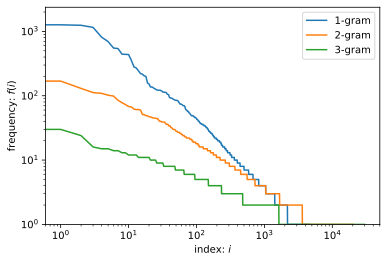

In [36]:
f  = [j for (word, j) in vocab.token_freqs_]
fb = [j for (word, j) in bigram_vocab.token_freqs_]
ft = [j for (word, j) in trigram_vocab.token_freqs_]

plt.plot(range(len(f)), f, label='1-gram')
plt.plot(range(len(fb)), fb, color="C1", label='2-gram')
plt.plot(range(len(ft)), ft, color="C2", label='3-gram')

plt.ylim(1)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('index: $i$')
plt.ylabel('frequency: $f(i)$');

This figure shows that beyond unigram words, the distribution of unique subsequences of words also appear to be following Zipf’s law but with decreasing decay rates as $n$ increases. This is nice because we know that more meaning with higher $n$ (although perhaps with increasing noise) and that the same structure seems to persist over different scales. 

For example, the theoretical upper bound for the number of $n$-grams is $|V|^n$ where $|V|$ is the size of the vocabulary. This is $3.5 \times 10^{13}$ for trigrams. For instance, the fact that there are around $20$ trigrams which occur at least $10$ times in a corpus of size $3.3 \times 10^4$ gives us hope that there is quite a lot of structure in language. This is contained the Zipf's law plot above, but perhaps more easily visualized in the following cumulative plot which shows that there is still some curvature even with higher $n$:

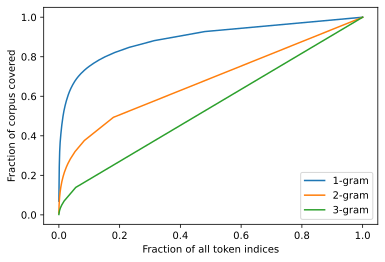

In [37]:
def cumulative(vocab):
    c = []
    f = [v[1] for v in vocab.token_freqs_]
    for i in range(len(vocab.token_freqs_)):
        c.append(sum(f[:i+1]))
    return c

plt.plot(np.linspace(0, 1, len(vocab)-1), np.array(cumulative(vocab)) / len(corpus), label='1-gram')
plt.plot(np.linspace(0, 1, len(bigram_vocab)-1), np.array(cumulative(bigram_vocab)) / len(corpus), color="C1", label='2-gram')
plt.plot(np.linspace(0, 1, len(trigram_vocab)-1), np.array(cumulative(trigram_vocab)) / len(corpus), color="C2", label='3-gram')
plt.ylabel("Fraction of corpus covered")
plt.xlabel("Fraction of all token indices")
plt.legend();

As can be inferred in the above two plots, many *n*-grams occur with low frequency.
In the log-scale frequency graph, majority of the mass is concentrated on the right tail of the graph which are tokens of low frequency. And in the above graph, we see that contributions to corpus coverage becomes linear with increasing index. This makes certain methods unsuitable for language modeling and motivates the use of deep learning models. We will discuss this in the next section.

In [38]:
rare = lambda vocab: [t for t in vocab.token_freqs_ if t[1] <= 2]
print("Fraction of rare tokens in a vocabulary:")
print(f'    1-gram: {len(rare(vocab)) / len(vocab):.3f}')
print(f'    2-gram: {len(rare(bigram_vocab)) / len(bigram_vocab):.3f}')
print(f'    3-gram: {len(rare(trigram_vocab)) / len(trigram_vocab):.3f}')

Fraction of rare tokens in a vocabulary:
    1-gram: 0.690
    2-gram: 0.917
    3-gram: 0.984


## Language models

In the previous sections we saw how to map text sequences into tokens which can be indexed with integers. Consequently, text sequences of length $T$ can be represented as an integer sequence $x_1, \ldots, x_T.$ The goal of **language models** then is to estimate the joint probability $p(x_1, \ldots, x_T)$ of whole sentences.

By Bayes' law, we can use language models to generate natural text just on its own by drawing one token at a time conditioned on the context: $x_t \sim p(x_t \mid x_1, \ldots, x_{t-1}).$ In a speech recognition problem, for example, ambiguity in speech can be resolved by considering the most probable translation. Or it can rule out outlandish sentences from being considered.

### Learning language models

Recall the chain rule:

$$p(x_1, \ldots, x_T) = p(x_1)\prod_{t=2}^T p\left({x}_{t} \mid {x}_{t-1}, \ldots, {x}_{1}\right).$$

This is a product of the initial probability of the first word followed by the probability of next words conditioned on the previous words. Instead of estimating the probabilities on the right hand side directly, we can make some Markov approximations:


$$\begin{aligned}
&p\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=p\left(x_{1}\right)\, p\left(x_{2}\right)\, p\left(x_{3}\right)\, p\left(x_{4}\right) \\
&p\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=p\left(x_{1}\right)\, p\left(x_{2} \mid x_{1}\right)\, p\left(x_{3} \mid x_{2}\right)\, p\left(x_{4} \mid x_{3}\right) \\
&p\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=p\left(x_{1}\right)\, p\left(x_{2} \mid x_{1}\right)\, p\left(x_{3} \mid x_{1}, x_{2}\right)\, p\left(x_{4} \mid x_{2}, x_{3}\right) .
\end{aligned}$$

Higher orders correspond to longer dependencies. Each of the probabilities on the right hand side are then **language model parameters** which we will learn from the data. The first thing to note here is that this requires a large text corpus (e.g. all Wikipedia entries, Project Gutenberg, or all text posted on the Web).

#### Word frequency

The probability of words can be calculated from the **relative word frequency** of a given word in the training dataset. The estimate $\hat{p}(x_1)$ of the first word can be calculated as the probability of any sentence starting with the word $x_1.$ A slightly less accurate but faster approach would be to count all occurrences of the word $x_1$ and divide it by the total number of words in the corpus. This works fairly well, particularly for frequent words. Next we estimate 

$$\hat{p}(x_2 \mid x_1)=\frac{ n(x_1, x_2) }{ n(x_1) }$$ 

where $n(x)$ and $n(x, x^\prime)$ are the number of occurrences of singletons and *consecutive* word pairs, respectively. Unfortunately, estimating the probability of a word pair is more difficult, since the occurrences of the sequence $x_1, x_2$ are a lot less frequent. If the dataset is small or if the words are very rare, we might not find even a single one of them, or we might even get float underflow issues. Things are way worse for trigrams as suggested by looking at statistics of *n*-grams above.

#### Laplace smoothing

A common strategy to fill in probabilities of rare word combinations is to use **Laplace smoothing** which is a way of adding small constant to all counts. For starters, this solves the issue of floating point underflow. Let $m$ be the number of unique words and $n$ be the total number of words. Then:

$$
\begin{aligned}
\hat{p}(x) &=\frac{n(x)+\frac{1}{m}\Delta n_{1}}{n+\Delta n_{1}}, \\ \\
\hat{p}\left(x^{\prime} \mid x\right) 
&=
\frac
{n\left(x, x^{\prime}\right)+ \hat{p}\left(x^{\prime}\right) \Delta n_{2}}
{n(x)+ \Delta n_{2}}, \\ \\
\hat{p}\left(x^{\prime \prime} \mid x, x^{\prime}\right)
&=
\frac
{n\left(x, x^{\prime}, x^{\prime \prime}\right)+\hat{p}\left(x^{\prime \prime}\right)\Delta n_{3}}
{n\left(x, x^{\prime}\right)+\Delta n_{3}}.
\end{aligned}
$$

Here $\Delta n_1, \Delta n_2,$ and $\Delta n_3$ are hyperparameters. Note that these have the dimension of count since they increment the total count in the denominator. For the numerator, count increments for occurrences of the word are scaled by the word probability. Taking $\Delta n_1 = \Delta n_2 = \Delta n_3 = 0,$ no smoothing is applied. On the other hand, if we take $\Delta n_1 \to +\infty,$ we get fixed word probabilities $\hat{p}(x) \to \frac{1}{m}$ and so on.

#### The need for deep learning

Even with Laplace smoothing, counting frequency gets bad pretty quickly. There really is no way to escape rarity of *n*-grams &mdash; we just get a model that assigns equal probabilities to rare word sequences. And there is the problem of storing all counts of words and their combinations. Finally, this entirely ignores the meaning of the words. For example, replacing words with a synonym can drive the probability of a sentence down. In the next sections, we will look at deep learning based models and how these models solve the problems described here.

### Perplexity

For classification problems, we typically use cross-entropy which encourage models to have higher predict probabilities on the true class for each example, and allows any other distribution of probabilities for the other classes. This allows some flexibility for the model during training. To evaluate a language model that gives a joint distribution $p$, we can average the cross-entropy of the probability of each word conditioned on each context:

$$
\frac{1}{n} \sum_{t=1}^{n}-\log p\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

where $x_t$ is the actual token observed at time step $t$ from the sequence. Note that in terms of information content and compression, this is the probability distribution which allows us to spend the minimum number of bits in compressing the sequence. This makes the performance on documents of different lengths comparable. For historical reasons, the quantity

$$
\exp\left(-\frac{1}{n} \sum_{t=1}^{n}\log p\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)\right)
$$

is used in literature called the **perplexity**. The idea is that a model which has low perplexity is least surprised or perplexed about the generated token since it already assigned a high probability to it. For example, a model which correctly predicts all next words gets a perplexity of $1$, since the logarithm terms all evaluate to $\log 1 = 0.$ Note that the $-\log p \geq 0$ for $p \in [0, 1]$ so that the the perplexity has range $[1, +\infty).$ The worst case occurs when the model always predict zero probability on the next word. 

**Baseline perplexity.** Consider the language model which assigns $\frac{1}{m}$ where $m$ is the number of unique words, then $\exp\left(\frac{1}{n} \sum_{t=1}^{n}\log m \right) = m$ which acts as a baseline perplexity. Observe that the baseline perplexity of a language model is proportional to the number of unique tokens in the text makes sense as the number of tokens can be considered as a rough estimate of the complexity of the text. In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it (i.e. the trivial encoding). Hence, this provides a nontrivial upper bound that any useful model must beat.

### Partitioning sequences

Before introducing the model architecture, we first have to think about how to read random minibatches of input and target sequences. For this we will assume that the model processes a minibatch of sequence with a predefined length at a time.

Suppose the corpus has total length $T$ which we will partition into subsequences containing $n$ tokens. To introduce randomness into starting indices, at the beginning of each epoch, discard $d \in [0, n)$ tokens from the beginning of the text where $d$ is chosen at random. This partitioning results in $r = \lfloor (T - d)/n \rfloor$ subsequences. For example, the first subsequence is $\mathbf x_d := (x_{d},\ldots, x_{d+n-1})$ followed by $\mathbf x_{d+n}$ and so on with the final subsequence being $\mathbf x_{d + n(r-1)}.$

Since a language model wants to predict the next token, the targets are the original sequence shifted by one token. The target sequence for any input sequence $\mathbf x_b$ is $\mathbf x_{b+1}$ for $b = d, d+n, \ldots, d + n(r-1).$ Note that the target sequences have the same length as input sequences. A mini-batch $B$ then corresponds to a subset of these possible values for $b.$

```{margin}
Figure source:<br>
[`d2l.ai/ch9`](https://www.d2l.ai/chapter_recurrent-neural-networks/index.html)
```
```{figure} ../../img/lang-model-data.svg
---
width: 80%
name: lang-model-data
---
Input and target subsequences for the text tokenized by character. The partitioned datasets are generated with $r = 5,$ $n=5$ and $d = 2.$
```


In [60]:
n = 5
train_corpus = corpus[pyrandom.randint(0, n-1):]
num_subseqs = (len(train_corpus) - 1) // n

In [63]:
len(corpus), len(train_corpus), num_subseqs * n

(32775, 32774, 32770)

In [ ]:
def sequential_dataloader(corpus, batch_size, num_steps):
    